In [1]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from glob import glob
import os
from tqdm import tqdm
from PIL import Image

fns = glob("/media/mlfavorfit/sdb/kandinsky_prior_train/*")


json_like = []
for fn in tqdm(fns, total=len(fns)):
    temp_dict = {"file_name":None, "text":None}

    img = Image.open(fn)
    file_name = os.path.basename(fn)
    text = "{FavorfitStyle}" + clip_image_to_text.inference(img, clip_model, mode="fast")

    temp_dict["file_name"] = file_name
    temp_dict["text"] = text

    json_like.append(temp_dict)

100%|██████████| 1626/1626 [05:22<00:00,  5.03it/s]


In [3]:
import json

with open("/media/mlfavorfit/sdb/kandinsky_prior_train/metadata.jsonl", mode="w") as f:
    for cur in json_like:
        json.dump(cur, f)
        f.write("\n")

In [2]:
import random
from PIL import Image
from PIL.ImageOps import expand

from diffusers.utils import make_image_grid
from utils import *

import torch
from diffusers import KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline

from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky


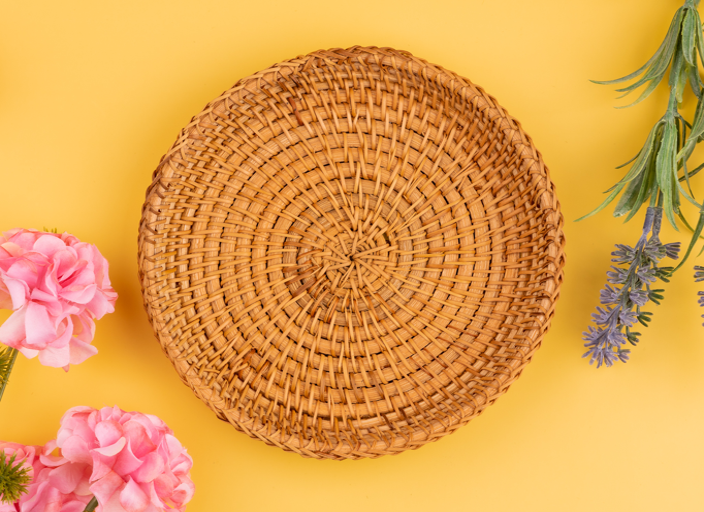

In [201]:
init_image = Image.open("/media/mlfavorfit/sdb/favorfit_templates/templates/90/645.jpg").convert("RGB")
init_image = resize_store_ratio(init_image, 512)
init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
width, height = init_image.size
init_image

In [202]:
import torch
import numpy as np

from transformers import pipeline
from diffusers.utils import load_image

from diffusers import KandinskyV22PriorPipeline, KandinskyV22ControlnetImg2ImgPipeline
# let's take an image and extract its depth map.
def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    depth_image = image
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint, depth_image

# We can use the `depth-estimation` pipeline from transformers to process the image and retrieve its depth map.
depth_estimator = pipeline("depth-estimation")
hint, depth_image = make_hint(init_image, depth_estimator)
hint = hint.unsqueeze(0).half().to("cuda")

# Now, we load the prior pipeline and the text-to-image controlnet pipeline
pipe_prior = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
pipe_prior = pipe_prior.to("cuda")

pipe = KandinskyV22ControlnetImg2ImgPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-controlnet-depth", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")


No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

In [203]:
important_keywords = ", natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
caption = clip_image_to_text.inference(init_image, clip_model, mode="simple", remove_color=True)
caption

'wicker flowers basket'

In [230]:
prompt = "green theme, " + important_keywords
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

seed = random.randint(0,10000)

100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


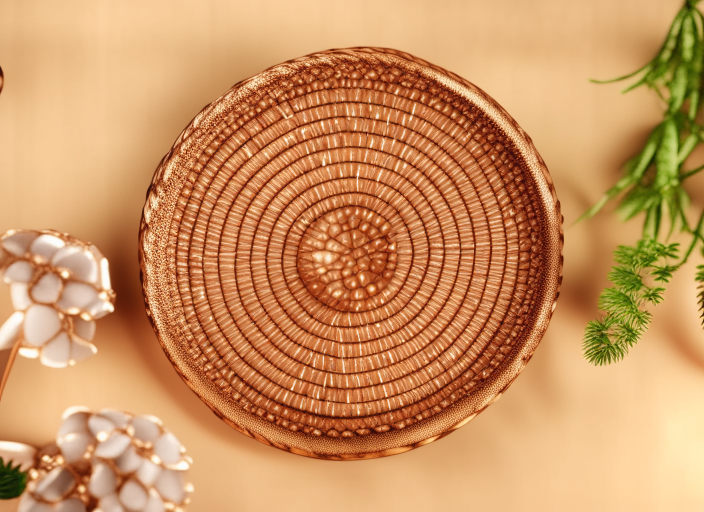

In [231]:
generator = torch.Generator(device="cuda").manual_seed(seed)

image_emb, zero_image_emb = pipe_prior(
    prompt=prompt, negative_prompt=negative_prompt, generator=generator
).to_tuple()

generated_image = pipe(
    image=init_image,
    image_embeds=image_emb,
    negative_image_embeds=zero_image_emb,
    hint=hint,
    num_inference_steps=50,
    generator=generator,
    guidance_scale=4.0,
    strength=0.15,
    height=height,
    width=width,
).images[0]
generated_image

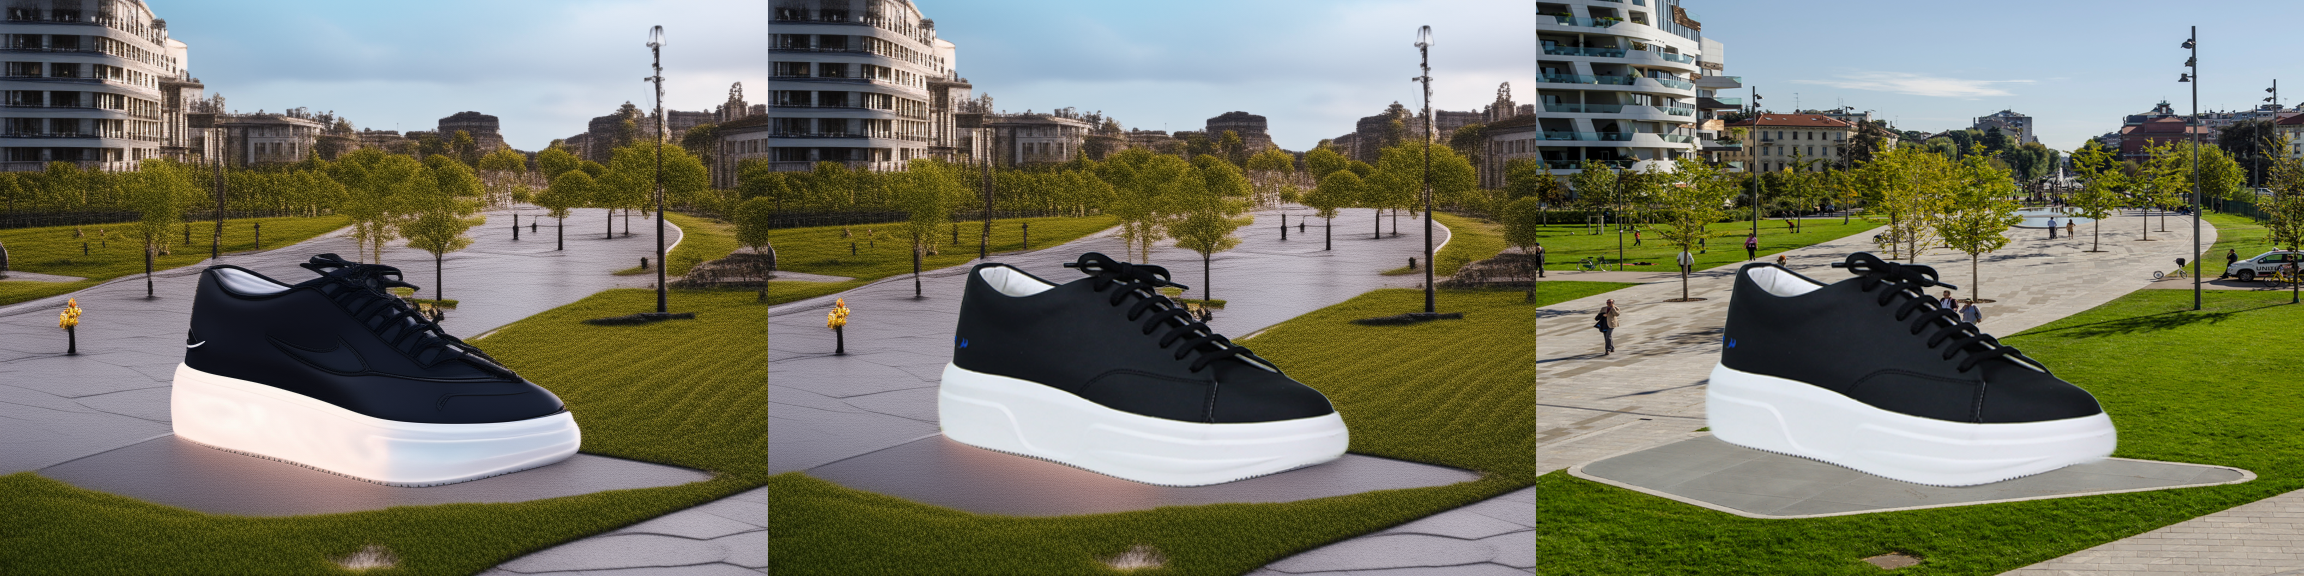

In [9]:
composed_image = composing_image(generated_image, init_image, mask.convert("RGB"))
make_image_grid([generated_image, composed_image, init_image], rows=1, cols=3)

In [10]:
generated_image = composed_image

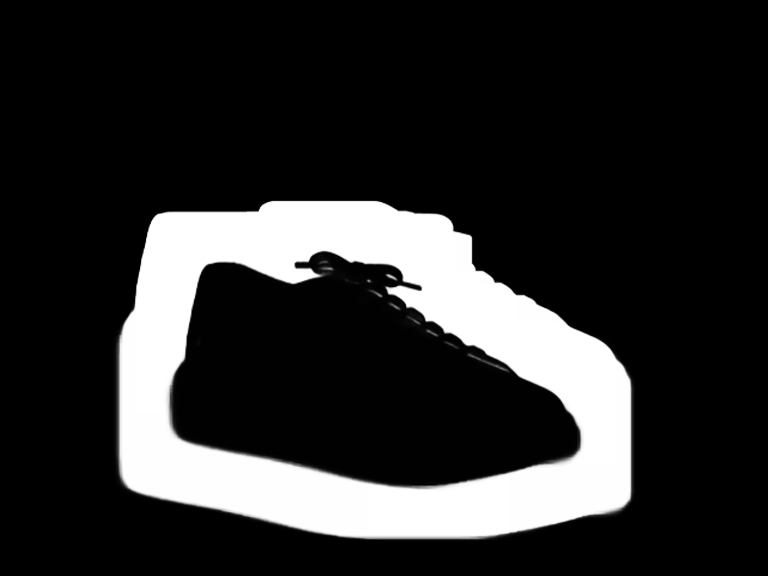

In [11]:
import numpy as np
from PIL.ImageOps import invert

expand_mask = cv2.dilate(np.array(mask.convert("L")), np.ones((3,3)), iterations=50)
expand_mask

mask_np = np.array(invert(mask.convert("L")))
exp_mask_np = np.array(expand_mask)

combine_mask = mask_np * (exp_mask_np/255) + exp_mask_np * (1-exp_mask_np/255)
combine_mask = Image.fromarray(combine_mask).convert("RGB")
combine_mask

In [12]:
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_inpainting import KandinskyV22InpaintPipeline

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


In [13]:
prompt = f"shadow, " + caption
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

seed = random.randint(0,10000)

In [14]:
generator = torch.Generator(device="cuda").manual_seed(seed)
prior_output = prior_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=generator
    )
output_image = pipeline(image=generated_image, 
                        mask_image=combine_mask, 
                        **prior_output, 
                        height=height, 
                        width=width, 
                        num_inference_steps=20,
                        strength=0.2,
                        guidance_scale=3.0,
                        generator=generator).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


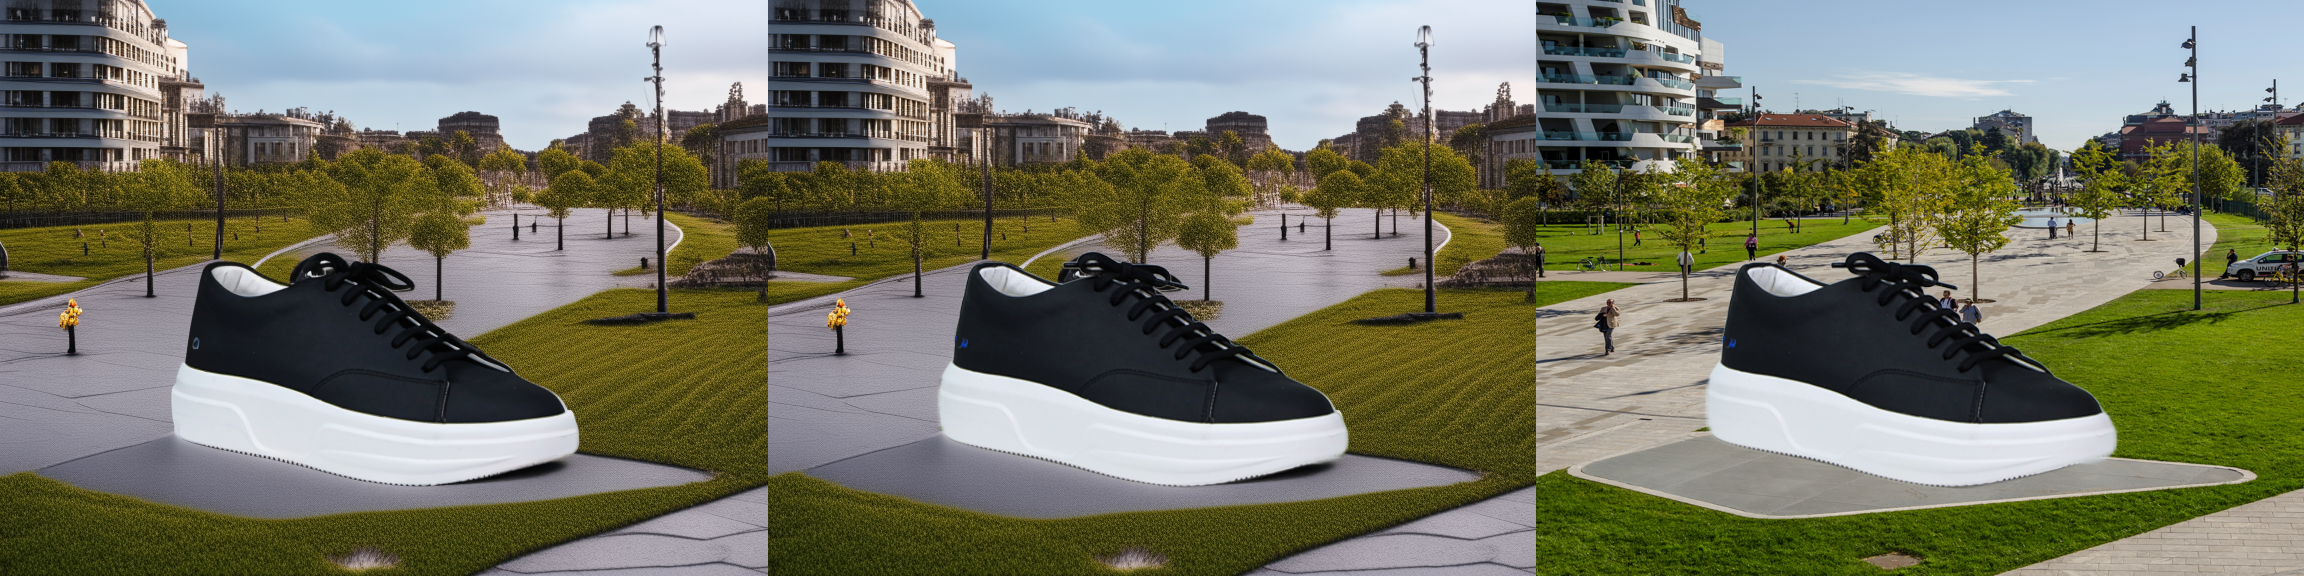

In [15]:
composed_image = composing_image(init_image, output_image, invert(mask).convert("RGB"))
make_image_grid([output_image, composed_image, init_image], rows=1, cols=3)